In [1]:
import pandas as pd
import numpy as np
import nltk
import string, re
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [3]:
data = '../../data/interim/enron-dataset-clean-v1.pkl'
emails = pd.read_pickle(data)
emails.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [4]:
priority_df = emails.loc[:, ['Date', 'From', 'Subject', 'content']]
priority_df.set_index('Date', inplace=True)
priority_df.sort_index(inplace=True)
priority_df.loc[:, ['Subject', 'content']] = priority_df.loc[:, ['Subject', 'content']].apply(lambda x: x.str.lower())
priority_df.shape

(517401, 3)

In [5]:
priority_df.head()

,From,Subject,content
Date,,,
1980-01-01,(outlook.team@enron.com),3 - urgent - to prevent loss of information,critical migration information:\n\n1. your sch...
1980-01-01,(rosalee.fleming@enron.com),university of houston reception,calling all alumni!\n \nuniversity of ho...
1980-01-01,(tori.wells@enron.com),re: update from cousins in missouri,letter dictated by ken lay\n\n\n\nhello janice...
1980-01-01,(rosalee.fleming@enron.com),re: energy tf final report,mr. sikes -\n\nkenneth l. lay is the chairman ...
1980-01-01,(kay.mann@enron.com),"re: bluedog change order #2, rev 4","hi brian,\n\nhere are my observations/question..."


In [6]:
priority_df.groupby('From').aggregate('count').sort_values('Subject', ascending=False).head()

,Subject,content
From,,
(kay.mann@enron.com),16735,16735
(vince.kaminski@enron.com),14368,14368
(jeff.dasovich@enron.com),11411,11411
(pete.davis@enron.com),9149,9149
(chris.germany@enron.com),8801,8801


In [6]:
priority_train = priority_df.iloc[:int(priority_df.shape[0]*0.9)]
priority_test = priority_df.iloc[int(priority_df.shape[0]*0.9):]
print(priority_train.shape)
print(priority_test.shape)

(465660, 3)
(51741, 3)


In [11]:
from_weight = priority_train.groupby('From', as_index=False).Subject.count()

In [12]:
from_weight['weight'] = from_weight.Subject.apply(lambda x: np.log(x+1))
from_weight.drop('Subject', axis=1, inplace=True)
from_weight.sort_values('weight', ascending=False).head()

,From,weight
10742,(kay.mann@enron.com),9.712872
10733,(vince.kaminski@enron.com),9.572828
10732,(jeff.dasovich@enron.com),9.330254
10703,(enron.announcements@enron.com),9.058121
10718,(sara.shackleton@enron.com),9.044758


In [13]:
is_thread = priority_train.Subject.str.contains('re: ')
threads = priority_train[is_thread]
re_subject_split = threads.Subject.str.strip('re:')

In [14]:
thread_matrix = pd.concat((threads['From'], re_subject_split), axis=1)

In [15]:
thread_matrix.reset_index(inplace=True, drop=True)

In [16]:
thread_matrix.head()

,From,Subject
0,(tori.wells@enron.com),update from cousins in missouri
1,(rosalee.fleming@enron.com),energy tf final report
2,(kay.mann@enron.com),"bluedog change order #2, rev 4"
3,(susan.scott@enron.com),erms traders in enpow
4,(sherri.sera@enron.com),your not


In [17]:
thread_senders = thread_matrix.iloc[:, 0]
senders_freq = thread_senders.groupby(thread_senders).count()

In [18]:
senders_dict = {
    'From': senders_freq.index.tolist(),
    'freq': list(senders_freq.values),
    'weight': list(senders_freq.transform(lambda x: np.log(x+1)))
}

In [19]:
senders_weight = pd.DataFrame(senders_dict)

In [20]:
senders_weight.head()

,From,freq,weight
0,(tori.wells@enron.com),27,3.332205
1,(lys@a-klaw.com),2,1.098612
2,(geresj@tdusa.com),1,0.693147
3,(lga@mother.com),2,1.098612
4,(jeff_walker@i2.com),4,1.609438


In [18]:
thread_subs = thread_matrix.iloc[:, 1].unique()

In [ ]:
thread_counts = {
    'freq': [],
    'time_span': [],
    'weight': []
}

for thread in thread_subs:
    thread_times = priority_train.index[priority_train.Subject.str.contains(thread, regex=False) | priority_train.Subject.str.contains('re: ' + thread, regex=False)]
    thread_freq = len(thread_times)
    min_time = thread_times.min()
    max_time = thread_times.max()
    time_span = (max_time - min_time).seconds
    if thread_freq<2:
        thread_counts['freq'].append(np.nan)
        thread_counts['time_span'].append(np.nan)
        thread_counts['weight'].append(np.nan)
    else:
        try:
            weight = thread_freq / time_span
            log_weight = 10 + np.log10(weight)
        except ZeroDivisionError:
            log_weight = np.mean(thread_counts['weight'])
        thread_counts['freq'].append(thread_freq)
        thread_counts['time_span'].append(time_span)
        thread_counts['weight'].append(log_weight)

In [ ]:
thread_weights = pd.DataFrame(thread_counts)
thread_weights.dropna(inplace=True)
thread_weights['thread'] = thread_matrix.iloc[:, 1]

In [22]:
thread_weights.head()

,freq,time_span,weight,thread
0,4.0,60300.0,5.821743,update from cousins in missouri
1,4.0,61920.0,5.810229,energy tf final report
2,7.0,25080.0,6.445771,your not
3,11.0,66389.0,6.219297,perd
4,12.0,33540.0,6.553618,ge releas


In [24]:
vec = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'))

In [25]:
thread_tdm = vec.fit_transform(thread_weights.thread)

In [26]:
thread_tdm = pd.DataFrame(thread_tdm.toarray(), columns=vec.get_feature_names())

In [27]:
term_weights = []
for term in thread_tdm.columns:
    weight = thread_weights.weight[thread_weights.thread.str.contains(term, regex=False)].mean()
    term_weights.append(weight)

In [28]:
thread_term_weights = pd.DataFrame.from_dict({
    'term': thread_tdm.columns,
    'weight': term_weights
})

In [24]:
thread_term_weights.sort_values('weight', ascending=False).head()

,term,weight
251,646,10.957523
185,3483,10.957523
4055,parpak,10.483675
2877,informed,10.171952
2569,graphics,9.176091


In [ ]:
priority_train.content = priority_train.content.str.replace('[^\w\s]','', regex=True)

In [ ]:
priority_train.content = priority_train.content.str.replace('\b\d+\b', '', regex=True)

In [ ]:
vec = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), min_df=10 )

In [ ]:
msg_tdm = vec.fit_transform(priority_train.content)

In [ ]:
msg_tdm = pd.SparseDataFrame(msg_tdm)

In [ ]:
msg_tdm.columns = vec.get_feature_names()

In [ ]:
msg_terms = pd.DataFrame.from_dict({
    'term': vec.get_feature_names(),
    'freq': list(msg_tdm.sum())
})

In [ ]:
msg_terms['weight'] = msg_terms.freq.apply(lambda x: np.log(x))

In [26]:
msg_terms.iloc[np.random.randint(0, 40000, size=(5, )), :]

,freq,term,weight
21802,16.0,720300,2.772589
24107,10.0,9164410496,2.302585
21924,191.0,732,5.252273
29932,3829.0,apologize,8.250359
8281,22.0,17times,3.091042


In [8]:
def get_weights(search_term, weight_df, term=True):
    search_term = str(search_term)
    if (len(search_term)>0):
        if term:
            term_match = False
            for search_item in search_term:
                match = weight_df.term.str.contains(search_item, regex=False)
                term_match = term_match | match
        else:
            term_match = weight_df.thread.str.contains(search_term, regex=False)
        
        match_weights = weight_df.weight[term_match]
        if len(match_weights)<1:
            return 1
        else:
            return match_weights.mean()
    else:
        return 1

In [9]:
def rank_message(msg):
    # First, using the from weights
    from_wt = from_weight[from_weight['From']==msg['From']]
    if len(from_wt)>0:
        msg_from_wt = from_wt.weight
    else:
        msg_from_wt = 1
    
    # Second, using senders weights from threads
    senders_wt = senders_weight[senders_weight['From']==msg['From']]
    if len(senders_wt)>0:
        msg_thread_from_wt = senders_wt.weight
    else:
        msg_thread_from_wt = 1
        
    # Then, from thread activity
    is_thread = len(msg.Subject.split('re: ')) > 1
    if is_thread:
        subject = msg.Subject.split('re: ')[1]
        msg_thread_activity_wt = get_weights(subject, thread_weights, term=False)
    else:
        msg_thread_activity_wt = 1
        
    # Then, weights based on terms in threads
    try:
        sub_vec = vec.fit_transform([msg['Subject']])
        msg_thread_terms = vec.get_feature_names()
        msg_thread_term_wt = get_weights(msg_thread_terms, thread_term_weights)
    except:
        # Some subjects from the test set result in empty vocabulary
        msg_thread_term_wt = 1
    
    # Then, weights based on terms in message
    try:
        msg_vec = vec.fit_transform([msg['content']])
        msg_terms = vec.get_feature_names()
        msg_terms_wt = get_weights(msg_terms, msg_term_weights)
    except:
        # Some subjects from the test set result in empty vocabulary
        msg_terms_wt = 1
    
    # Calculating Rank
    rank = float(msg_from_wt) * float(msg_thread_from_wt) * float(msg_thread_activity_wt) * float(msg_thread_term_wt) * float(msg_terms_wt)
    
    return [msg.name, msg['From'], msg['Subject'], rank]

In [52]:
rank_dict = {
    'date': [],
    'from': [],
    'subject': [],
    'rank': []
}

for i in range(priority_train.shape[0]):
    result = rank_message(priority_train.iloc[i, :])
    rank_dict['date'].append(result[0])
    rank_dict['from'].append(result[1])
    rank_dict['subject'].append(result[2])
    rank_dict['rank'].append(result[3])
    update_progress(i/priority_train.shape[0])

Progress: [####################] 100.0%


In [53]:
rank_df = pd.DataFrame.from_dict(rank_dict)

In [3]:
priority_threshold = rank_df['rank'].median()
print(priority_threshold)

170.61861518695991


In [4]:
rank_df['priority'] = rank_df['rank']>priority_threshold

In [13]:
rank_df.head()

,date,from,rank,subject
0,1980-01-01,(outlook.team@enron.com),179.459524,3 - urgent - to prevent loss of information
1,1980-01-01,(rosalee.fleming@enron.com),310.673189,university of houston reception
2,1980-01-01,(tori.wells@enron.com),594.246703,re: update from cousins in missouri
3,1980-01-01,(rosalee.fleming@enron.com),1804.662818,re: energy tf final report
4,1980-01-01,(kay.mann@enron.com),590.674601,"re: bluedog change order #2, rev 4"


In [61]:
rank_df[~rank_df['priority']].head()

,date,from,rank,subject,priority
5,1980-01-01,(john.griffith@enron.com),154.973708,don't forget to register!,False
9,1980-01-01,(john.griffith@enron.com),154.973708,don't forget to register!,False
12,1980-01-01,(doug.gilbert-smith@enron.com),56.325155,send in your registration card,False
13,1980-01-01,(phillip.allen@enron.com),50.406585,,False
20,1980-01-01,(don.baughman@enron.com),107.951010,supplies for sailing trip jan. 27,False


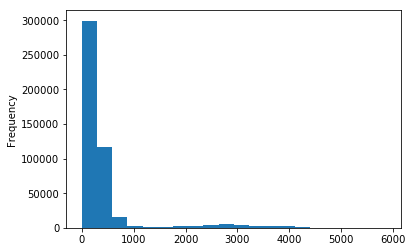

In [7]:
rank_df['rank'].plot.hist(bins=20)

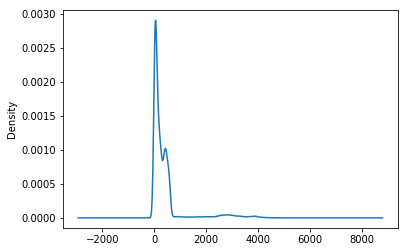

In [6]:
rank_df['rank'].plot.density()

In [27]:
test_rank_dict = {
    'date': [],
    'from': [],
    'subject': [],
    'rank': []
}

for i in range(priority_test.shape[0]):
    result = rank_message(priority_test.iloc[i, :])
    test_rank_dict['date'].append(result[0])
    test_rank_dict['from'].append(result[1])
    test_rank_dict['subject'].append(result[2])
    test_rank_dict['rank'].append(result[3])
    update_progress(i/priority_test.shape[0])

Progress: [####################] 100.0%


In [28]:
test_rank_df = pd.DataFrame.from_dict(test_rank_dict)

In [25]:
priority_threshold = test_rank_df['rank'].median()
print(priority_threshold)

6.650229808226872


In [26]:
test_rank_df['priority'] = test_rank_df['rank']>priority_threshold

In [29]:
test_rank_df[test_rank_df.priority].head()

,date,from,rank,subject,priority
3,2001-11-27 01:39:16,(christian.yoder@enron.com),22.676505,hyda index -2,True
9,2001-11-27 01:56:04,(s..bradford@enron.com),15.506970,fw: physical gas collections 11/26/01,True
10,2001-11-27 01:56:07,(ken.e.randolph@dynegy.com),17.738310,re: lunch,True
11,2001-11-27 01:56:38,(mariella.mahan@enron.com),7.117388,fw: guam information,True
15,2001-11-27 01:58:02,(cara.semperger@enron.com),28.390146,re: dart product,True


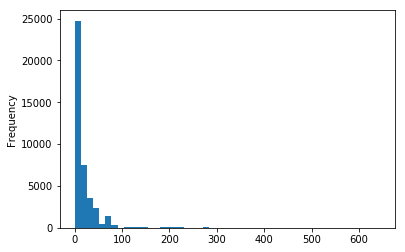

In [23]:
test_rank_df['rank'].plot.hist(bins=50)

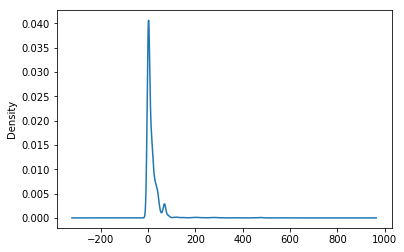

In [24]:
test_rank_df['rank'].plot.density()